<a href="https://colab.research.google.com/github/QingyunSun/Distributional-Robust-Kelly-Gambling/blob/master/DRKP20200610_CVXLayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade cvxpy

get_ipython().run_line_magic('pylab', 'inline')
import numpy as np
import cvxpy as cvx
import itertools
import torch
from tqdm.notebook import tqdm




Requirement already up-to-date: cvxpy in /usr/local/lib/python3.6/dist-packages (1.1.1)
Populating the interactive namespace from numpy and matplotlib


In [2]:
cvx.__version__

'1.1.1'

In [0]:

n = 20 # number of assets
K = int(n*(n-1)/2)# number of scenarios

# Monte Carlo sample
MC_N_SAMPLES = 100
MC_T = 50

N_TRAJ = 30

M = 1

import cvxpy as cvx
from cvxpylayers.torch import CvxpyLayer
# generate_ball_problem
pi_0 = cvx.Parameter(K, nonneg=True)
# rho_log = cvx.Parameter(K)
# rho = cvx.exp(rho_log)
rho = cvx.Parameter(K, nonneg=True)
R_cvx = cvx.Parameter((n,K), nonneg=True)


b = cvx.Variable(n)
mu = cvx.Variable(K)
log_growth = cvx.log(R_cvx.T@b )
rob_growth_rate = cvx.min(log_growth + mu  )
rob_growth_rate = rob_growth_rate - pi_0.T@mu - rho.T@cvx.abs(mu)
constraints = [cvx.sum(b) == 1, b >= 0] 
DRKP = cvx.Problem(cvx.Maximize(rob_growth_rate), constraints)

problem = DRKP
parameters=[R_cvx, pi_0, rho]

# assert problem.is_dcp()
policy =  CvxpyLayer(problem, parameters, [b])

In [5]:
# # Definitions 
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    
std = 0.5
seed = 2018
print('seed', seed)
np.random.seed(seed)
skill = np.random.randn(n)
beta = softmax( std*(skill))


TopTwoList = list(itertools.combinations(range(n),2))

pi = np.ones(K)
r = np.zeros((n,K))

for count in range(len(TopTwoList)):
    vector = np.zeros(n)
    first_place = TopTwoList[count][0]
    second_place = TopTwoList[count][1]
    total = beta[first_place]+beta[second_place]
    vector[first_place] = n*beta[second_place]/total
    vector[second_place] = n*beta[first_place]/total
    r[:,count]=vector

    pi[count] = beta[second_place]*beta[first_place]*(1/(1-beta[first_place])+ 1/(1-beta[second_place]))
    
pi /= sum(pi)
pi_horse = pi.copy()

mc_index = np.random.choice(r.shape[1], size = MC_N_SAMPLES * MC_T, p = pi)
T = MC_N_SAMPLES * MC_T
R = r.copy()

seed 2018


In [0]:
# #repeatable initialize
# log_pi_init = np.log(pi_horse) + 0.01*np.random.randn(K)
# pi_0_init = softmax(log_pi_init)

In [0]:
# plot(np.log(pi_horse)[order],'.' )

In [6]:
seed = 2020
print('seed', seed)
np.random.seed(seed)
NUM_TEST = 20
pi_test_list = []
for count in range(NUM_TEST):
    skill_test = np.random.randn(n)
    std = 1
    beta = softmax( std*(skill_test))


    TopTwoList = list(itertools.combinations(range(n),2))

    pi = np.ones(K)
    r = np.zeros((n,K))

    for count in range(len(TopTwoList)):
        vector = np.zeros(n)
        first_place = TopTwoList[count][0]
        second_place = TopTwoList[count][1]
        total = beta[first_place]+beta[second_place]
        vector[first_place] = n*beta[second_place]/total
        vector[second_place] = n*beta[first_place]/total
        r[:,count]=vector

        pi[count] = beta[second_place]*beta[first_place]*(1/(1-beta[first_place])+ 1/(1-beta[second_place]))
        
    pi /= sum(pi)
    pi_test_list.append( pi.copy() )

Pi_test = np.stack( pi_test_list ,axis=0)   

seed 2020


In [100]:
# Initialize:
Rho = torch.from_numpy(np.ones(K)*1e-4).requires_grad_(True)
log_Pi_0 = torch.from_numpy(np.zeros(K)).requires_grad_(True)
torch_variables = [log_Pi_0, Rho]
R_torch = torch.from_numpy(R)
Pi_test_torch = torch.from_numpy(Pi_test)
# Loss: 
def evaluate( R_torch, log_Pi_0, Rho, Pi_test_torch):
    Pi_0 = torch.nn.functional.softmax(log_Pi_0)
    b, = policy(R_torch, Pi_0, Rho)
    logs = torch.log(R_torch.T @ b)
    cost = - torch.sum(Pi_test_torch*logs[None,:])
    return   cost

# Training:
iters = 50
results = []
optimizer = torch.optim.Adam(torch_variables, lr=1e-4)
for i in range(iters):
    optimizer.zero_grad()
    loss = evaluate(R_torch, log_Pi_0, Rho, Pi_test_torch)
    loss.backward()
    optimizer.step()
    # Project so that Rho is non-negative 
    Rho.data = torch.max(Rho.data,torch.zeros_like(Rho.data))
    results.append(loss.item())
    print("(iter %d) loss: %g " % (i, results[-1]))
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


(iter 0) loss: -1.14347 
(iter 1) loss: -1.13211 
(iter 2) loss: -1.10964 
(iter 3) loss: -1.09212 
(iter 4) loss: -1.07848 
(iter 5) loss: -1.06195 
(iter 6) loss: -1.04391 
(iter 7) loss: -1.03077 
(iter 8) loss: -1.01777 
(iter 9) loss: -1.00525 
(iter 10) loss: -0.99304 
(iter 11) loss: -0.980782 
(iter 12) loss: -0.968752 
(iter 13) loss: -0.95688 
(iter 14) loss: -0.946428 
(iter 15) loss: -0.939755 
(iter 16) loss: -0.933321 
(iter 17) loss: -0.927832 
(iter 18) loss: -0.921649 
(iter 19) loss: -0.914931 
(iter 20) loss: -0.907836 
(iter 21) loss: -0.9 
(iter 22) loss: -0.891298 
(iter 23) loss: -0.88185 
(iter 24) loss: -0.872014 
(iter 25) loss: -0.865928 
(iter 26) loss: -0.865537 
(iter 27) loss: -0.865297 
(iter 28) loss: -0.865084 
(iter 29) loss: -0.864906 
(iter 30) loss: -0.864767 
(iter 31) loss: -0.864636 
(iter 32) loss: -0.864569 
(iter 33) loss: -0.864526 
(iter 34) loss: -0.864578 
(iter 35) loss: -0.864662 
(iter 36) loss: -0.864824 
(iter 37) loss: -0.865325 
(i

/usr/local/lib/python3.6/dist-packages/diffcp/cone_program.py:259: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


(iter 43) loss: -0.864674 
(iter 44) loss: -0.863716 
(iter 45) loss: -0.863231 
(iter 46) loss: -0.862746 
(iter 47) loss: -0.862518 
(iter 48) loss: -0.862179 
(iter 49) loss: -0.861665 


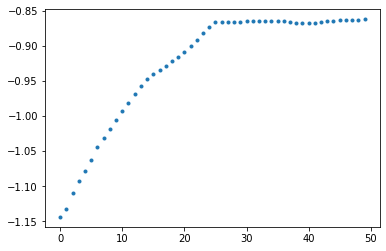

In [101]:
plt.plot(results,'.')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


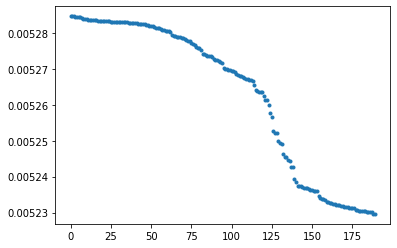

In [115]:
# order = np.argsort(pi_horse)[::-1]
Pi_0 = torch.nn.functional.softmax(log_Pi_0)
pi_0_trained = Pi_0.detach().numpy()

order_trained = np.argsort(pi_0_trained)[::-1]

rho_trained = Rho.detach().numpy()

pi_0_trained_upper = pi_0_trained+rho_trained
pi_0_trained_lower = pi_0_trained-rho_trained

plt.plot(  pi_0_trained[order_trained] , '.', label='pi nominal trained')



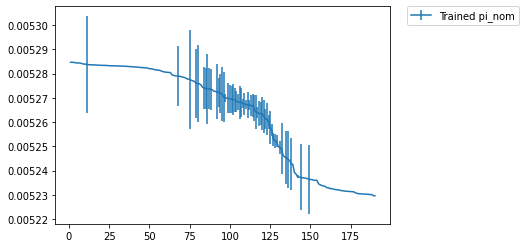

In [144]:
plt.subplot()
width = 2
barWidth = 0.9

order = np.argsort(pi)[::-1]
plt.errorbar( np.arange(1, K+1 ) , pi_0_trained[order_trained], yerr= pi_0_trained[order_trained]*rho_trained[order_trained], label = 'Trained pi_nom' )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [135]:
seed = 2020
print('seed', seed)
np.random.seed(seed)
NUM_TEST = 20
pi_test_list = []
for count in range(NUM_TEST):
    skill_test = np.random.randn(n)
    std = 0.5
    beta = softmax( std*(skill_test))


    TopTwoList = list(itertools.combinations(range(n),2))

    pi = np.ones(K)
    r = np.zeros((n,K))

    for count in range(len(TopTwoList)):
        vector = np.zeros(n)
        first_place = TopTwoList[count][0]
        second_place = TopTwoList[count][1]
        total = beta[first_place]+beta[second_place]
        vector[first_place] = n*beta[second_place]/total
        vector[second_place] = n*beta[first_place]/total
        r[:,count]=vector

        pi[count] = beta[second_place]*beta[first_place]*(1/(1-beta[first_place])+ 1/(1-beta[second_place]))
        
    pi /= sum(pi)
    pi_test_list.append( pi.copy() )

Pi_test = np.stack( pi_test_list ,axis=0)   

seed 2020


In [7]:

# Initialize:
Rho = torch.from_numpy(np.ones(K)*1e-4).requires_grad_(True)
log_Pi_0 = torch.from_numpy(np.log(np.mean(Pi_test, axis=0)) ).requires_grad_(True)
torch_variables = [log_Pi_0, Rho]
R_torch = torch.from_numpy(R)
Pi_test_torch = torch.from_numpy(Pi_test)
# Loss: 
def evaluate( R_torch, log_Pi_0, Rho, Pi_test_torch):
    Pi_0 = torch.nn.functional.softmax(log_Pi_0)
    b, = policy(R_torch, Pi_0, Rho)
    logs = torch.log(R_torch.T @ b)
    cost = - torch.sum(Pi_test_torch*logs[None,:])
    return   cost

# Training:
iters = 100
results = []
optimizer = torch.optim.Adam(torch_variables, lr=1e-4)
for i in range(iters):
    optimizer.zero_grad()
    loss = evaluate(R_torch, log_Pi_0, Rho, Pi_test_torch)
    loss.backward()
    optimizer.step()
    # Project so that Rho is non-negative 
    Rho.data = torch.max(Rho.data,torch.zeros_like(Rho.data))
    results.append(loss.item())
    print("(iter %d) loss: %g " % (i, results[-1]))
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


(iter 0) loss: -1.95276 
(iter 1) loss: -1.95445 
(iter 2) loss: -1.95436 
(iter 3) loss: -1.9542 
(iter 4) loss: -1.95402 


/usr/local/lib/python3.6/dist-packages/diffcp/cone_program.py:259: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


(iter 5) loss: -1.95366 
(iter 6) loss: -1.95328 
(iter 7) loss: -1.95284 
(iter 8) loss: -1.95233 
(iter 9) loss: -1.95179 
(iter 10) loss: -1.95147 
(iter 11) loss: -1.9513 
(iter 12) loss: -1.95115 
(iter 13) loss: -1.95099 
(iter 14) loss: -1.95083 
(iter 15) loss: -1.95065 
(iter 16) loss: -1.95047 
(iter 17) loss: -1.95029 
(iter 18) loss: -1.9501 
(iter 19) loss: -1.94989 
(iter 20) loss: -1.9497 
(iter 21) loss: -1.94948 
(iter 22) loss: -1.94923 
(iter 23) loss: -1.94898 
(iter 24) loss: -1.94872 
(iter 25) loss: -1.94842 
(iter 26) loss: -1.94826 
(iter 27) loss: -1.9481 
(iter 28) loss: -1.94794 
(iter 29) loss: -1.94778 
(iter 30) loss: -1.9476 
(iter 31) loss: -1.94743 
(iter 32) loss: -1.94725 
(iter 33) loss: -1.94706 
(iter 34) loss: -1.94686 
(iter 35) loss: -1.94665 
(iter 36) loss: -1.94656 
(iter 37) loss: -1.94659 
(iter 38) loss: -1.94655 
(iter 39) loss: -1.9465 
(iter 40) loss: -1.94647 
(iter 41) loss: -1.94646 
(iter 42) loss: -1.94643 
(iter 43) loss: -1.9463

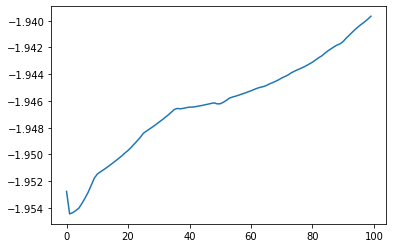

In [8]:
plt.plot(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


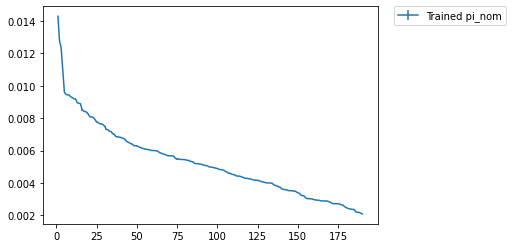

In [10]:
# order = np.argsort(pi_horse)[::-1]
Pi_0 = torch.nn.functional.softmax(log_Pi_0)
pi_0_trained = Pi_0.detach().numpy()

order_trained = np.argsort(pi_0_trained)[::-1]

rho_trained = Rho.detach().numpy()

pi_0_trained_upper = pi_0_trained+rho_trained
pi_0_trained_lower = pi_0_trained-rho_trained


plt.subplot()
width = 2
barWidth = 0.9

order = np.argsort(pi)[::-1]
plt.errorbar( np.arange(1, K+1 ) , pi_0_trained[order_trained], yerr= pi_0_trained[order_trained]*rho_trained[order_trained], label = 'Trained pi_nom' )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [15]:

# Initialize:
Rho = torch.from_numpy(np.ones(K)*1e-3).requires_grad_(True)
log_Pi_0 = torch.from_numpy(np.log(np.mean(Pi_test[0:10], axis=0)) ).requires_grad_(True)
torch_variables = [log_Pi_0, Rho]
R_torch = torch.from_numpy(R)
Pi_test_torch = torch.from_numpy(Pi_test)
# Loss: 
def evaluate( R_torch, log_Pi_0, Rho, Pi_test_torch):
    Pi_0 = torch.nn.functional.softmax(log_Pi_0)
    b, = policy(R_torch, Pi_0, Rho)
    logs = torch.log(R_torch.T @ b)
    cost = - torch.sum(Pi_test_torch*logs[None,:])
    return   cost

# Training:
iters = 100
results = []
optimizer = torch.optim.Adam(torch_variables, lr=1e-4)
for i in range(iters):
    optimizer.zero_grad()
    loss = evaluate(R_torch, log_Pi_0, Rho, Pi_test_torch)
    loss.backward()
    optimizer.step()
    # Project so that Rho is non-negative 
    Rho.data = torch.max(Rho.data,torch.zeros_like(Rho.data))
    results.append(loss.item())
    print("(iter %d) loss: %g " % (i, results[-1]))
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


(iter 0) loss: -1.30232 
(iter 1) loss: -1.24238 
(iter 2) loss: -1.18423 
(iter 3) loss: -1.13058 
(iter 4) loss: -1.0681 
(iter 5) loss: -1.00049 
(iter 6) loss: -0.930345 
(iter 7) loss: -0.863941 
(iter 8) loss: -0.791166 
(iter 9) loss: -0.709167 
(iter 10) loss: -0.610092 
(iter 11) loss: -0.575866 
(iter 12) loss: -0.562166 
(iter 13) loss: -0.552255 
(iter 14) loss: -0.545144 
(iter 15) loss: -0.538171 
(iter 16) loss: -0.53157 
(iter 17) loss: -0.526111 
(iter 18) loss: -0.520773 
(iter 19) loss: -0.515206 
(iter 20) loss: -0.509765 
(iter 21) loss: -0.504358 
(iter 22) loss: -0.498784 
(iter 23) loss: -0.493708 
(iter 24) loss: -0.488714 
(iter 25) loss: -0.483956 
(iter 26) loss: -0.479816 
(iter 27) loss: -0.475128 
(iter 28) loss: -0.46996 
(iter 29) loss: -0.465442 
(iter 30) loss: -0.460923 
(iter 31) loss: -0.456373 
(iter 32) loss: -0.452488 
(iter 33) loss: -0.448794 
(iter 34) loss: -0.445471 
(iter 35) loss: -0.442404 
(iter 36) loss: -0.439715 
(iter 37) loss: -0.4

/usr/local/lib/python3.6/dist-packages/diffcp/cone_program.py:259: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


(iter 54) loss: -0.392342 
(iter 55) loss: -0.390033 
(iter 56) loss: -0.387606 
(iter 57) loss: -0.3851 
(iter 58) loss: -0.382662 
(iter 59) loss: -0.380224 
(iter 60) loss: -0.377732 
(iter 61) loss: -0.375181 
(iter 62) loss: -0.372581 
(iter 63) loss: -0.370047 
(iter 64) loss: -0.367447 
(iter 65) loss: -0.364828 
(iter 66) loss: -0.362096 
(iter 67) loss: -0.359468 
(iter 68) loss: -0.356858 
(iter 69) loss: -0.354209 
(iter 70) loss: -0.351637 
(iter 71) loss: -0.349017 
(iter 72) loss: -0.346383 
(iter 73) loss: -0.343796 
(iter 74) loss: -0.341068 
(iter 75) loss: -0.338683 
(iter 76) loss: -0.336504 
(iter 77) loss: -0.334086 
(iter 78) loss: -0.331365 
(iter 79) loss: -0.328955 
(iter 80) loss: -0.326708 
(iter 81) loss: -0.324381 
(iter 82) loss: -0.32202 
(iter 83) loss: -0.319671 
(iter 84) loss: -0.317503 
(iter 85) loss: -0.315191 
(iter 86) loss: -0.312782 
(iter 87) loss: -0.310312 
(iter 88) loss: -0.307778 
(iter 89) loss: -0.305165 
(iter 90) loss: -0.302545 
(ite

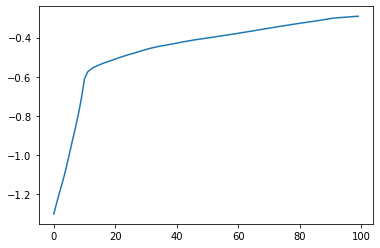

In [16]:
plt.plot(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


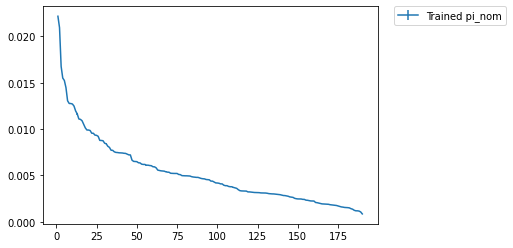

In [17]:
# order = np.argsort(pi_horse)[::-1]
Pi_0 = torch.nn.functional.softmax(log_Pi_0)
pi_0_trained = Pi_0.detach().numpy()

order_trained = np.argsort(pi_0_trained)[::-1]

rho_trained = Rho.detach().numpy()

pi_0_trained_upper = pi_0_trained+rho_trained
pi_0_trained_lower = pi_0_trained-rho_trained


plt.subplot()
width = 2
barWidth = 0.9

order = np.argsort(pi)[::-1]
plt.errorbar( np.arange(1, K+1 ) , pi_0_trained[order_trained], yerr= pi_0_trained[order_trained]*rho_trained[order_trained], label = 'Trained pi_nom' )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


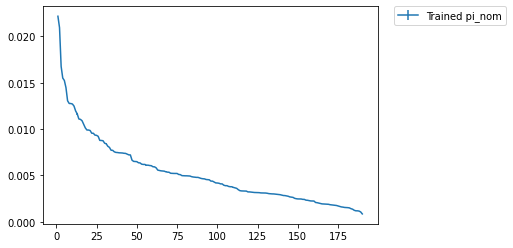

In [18]:
# order = np.argsort(pi_horse)[::-1]
Pi_0 = torch.nn.functional.softmax(log_Pi_0)
pi_0_trained = Pi_0.detach().numpy()

order_trained = np.argsort(pi_0_trained)[::-1]

rho_trained = Rho.detach().numpy()

pi_0_trained_upper = pi_0_trained+rho_trained
pi_0_trained_lower = pi_0_trained-rho_trained


plt.subplot()
width = 2
barWidth = 0.9

order = np.argsort(pi)[::-1]
plt.errorbar( np.arange(1, K+1 ) , pi_0_trained[order_trained], yerr= pi_0_trained[order_trained]*rho_trained[order_trained], label = 'Trained pi_nom' )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()